In [2]:
# %matplotlib inline
from __future__ import print_function
# from statsmodels.compat import lzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Lets quickly build an initial model and see how it is working
We will first import the dataset and check the contents/relevant columns. We will also quickly describe the data to ensure we have the right data which holds true to the assumptions of the model we are going to use 

Import and view data

In [3]:
beer_data=pd.read_csv('C:\\Users\\IN22915477\\OneDrive - Tesco\\Documents\\ROI Analytics\\2. Non BAU projects\\Pricing\\beer_data.csv')
beer_data.head(10)

,Year,Quarter,Quantity,Price
0,1977,1,23.00,142.17
1,1977,2,22.61,143.93
2,1977,3,23.41,146.50
3,1977,4,22.74,150.80
4,1978,1,22.04,160.00
5,1978,2,21.76,182.53
6,1978,3,21.61,186.20
7,1978,4,21.88,186.43
8,1979,1,20.51,211.70
9,1979,2,19.04,231.50


Describe the data
This will statistically describe the data, providing the range of values and overall distribution for all numerical variables. Describe also takes care of missing values as NAN values are ignored while describing the data i.e count only provides count of non missing values.

In [4]:
print('#rows : ', beer_data.shape[0])
print(beer_data.describe())

#rows :  91
              Year    Quarter   Quantity       Price
count    91.000000  91.000000  91.000000   91.000000
mean   1987.879121   2.483516  18.403956  250.440330
std       6.604435   1.119153   1.813380   37.010662
min    1977.000000   1.000000  15.890000  142.170000
25%    1982.000000   1.500000  17.040000  231.335000
50%    1988.000000   2.000000  18.170000  250.100000
75%    1993.500000   3.000000  19.355000  280.720000
max    1999.000000   4.000000  23.410000  300.400000


We see that there are no missing values in the data. Now we are going to train a Linear Regression Model on the dataset. Few basic things to call out before running the model. 
Linear Regression is one of the most powerful modelling techniques due to its ease of training as well as ease of interpretation. This means that LR models can be quickly trained, interpreted, aligned upon based on business logics and hence implemented. But LR models need to follow few assumptions which need to hold true so that the interpretation of the model is correct. In the section below we are going to test these assumptions. For a detailed view on this topic visit the link - https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

Before we go on to test the assumptions, lets quickly run a linear regression model. Few assumptions of LR are on variables that flow into the model whereas others are based on residuals of the model

In [93]:
# Fitting the model
linear_model = LinearRegression()
#linear_model.fit(linear_X, linear_y)
Quantity = np.array(beer_data['Quantity']).reshape(-1,1) # need to reshape the data in form of 1D array before running
Price = np.array(beer_data['Price']).reshape(-1,1)       # need to reshape the data in form of 1D array before running
linear_model.fit(Price,Quantity)
# Returning the R^2 for the model
linear_r2 = linear_model.score(Price,Quantity)
print('R^2: {0}'.format(linear_r2))

R^2: 0.9010972429919952


In [104]:
def calculate_residuals(model, features, label):
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': pd.Series(Quantity.flatten()), 'Predicted': pd.Series(predictions.flatten())})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    return df_results
results = calculate_residuals(linear_model,Price,Quantity)
results.head()

,Actual,Predicted,Residuals
0,23.00,23.439627,-0.439627
1,22.61,23.357769,-0.747769
2,23.41,23.238238,0.171762
3,22.74,23.038245,-0.298245
4,22.04,22.610351,-0.570351


Issues I faced while creating this 
1. First attempt - df_results = pd.DataFrame({'Actual': Quantity, 'Predicted': predictions}) - This gives a Value error as pandas dataframes does not accept scalars alone and needs a clearly defined index.
2. Second Attempt - df_results = pd.DataFrame({'Actual': Quantity, 'Predicted': predictions}, index=[0]) - This gives an exception erros "Exception: Data must be 1-dimensional" as the numpy arrays created are not 1D which is what is needed by pandas Dataframe structure
3. Third attempt -  df_results = pd.DataFrame({'Actual': [Quantity], 'Predicted': [predictions]}) - Gives single row dataframe - not something that I needed
4. Fourth attemp -  df_results = pd.DataFrame({'Actual': pd.Series(Quantity.flatten()), 'Predicted': pd.Series(predictions.flatten())}) - Does the trick. Flatten converts 2D dataframe into 1D. You can even do without the pd.Series command as the results would not be impacted.

Validating Assumptions
1. Linearity - This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable

C:\Users\IN22915477\Anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


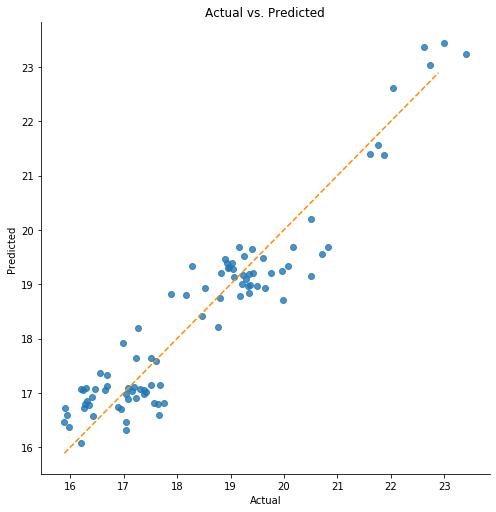

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
def plot_linear(model,features,label):
    results = calculate_residuals(linear_model,Price,Quantity)
    sns.lmplot(x='Actual',y='Predicted',data=results,fit_reg=False,size=7)
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
plot_linear(linear_model,Price,Quantity)

2. Normality - This means that error terms are normally distributed. Linear regressions other than Ordinary Least Squares (OLS) may also assume normality of the predictors or the label, but that is not the case here.A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals. To detect normality we can either look at the histogram or p-value from the Anderson-Darling test.

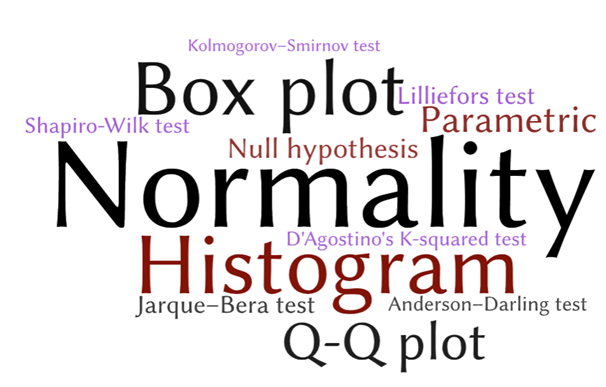

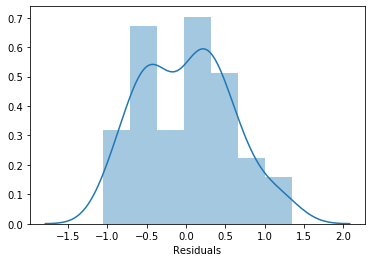

Residuals are normally distributed as per Anderson Darling test


In [113]:
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import normal_ad
def test_normality(model,features,label,p_value_thresh=0.05):
    #get the dataframe with residuals
    results = calculate_residuals(linear_model,Price,Quantity)
    #plot distribution of the variable of interest
    sns.distplot(results['Residuals'])
    plt.show()
    
    #Run AD test - This tests if sample is coming from a particular distribution. The distribution it takes are normal, 
    #exponential, logistic, or Gumbel (Extreme Value Type I) distributions. If the test statistic is larger than the critical
    #value then for the corresponding significance level, the null hypothesis (i.e., the data come from the chosen distribution)
    #can be rejected
    p_value = normal_ad(results['Residuals'])[1]
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed as per Anderson Darling test')
    else:
        print('Residuals are normally distributed as per Anderson Darling test')

test_normality(linear_model,Price,Quantity,p_value_thresh=0.05)



3. No Multicollinearity among predictors - This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model. Specifically, you can interpret a coefficient as “an increase of 1 in this predictor results in a change of (coefficient) in the response variable, holding all other predictors constant.” This becomes problematic when multicollinearity is present because we can’t hold correlated predictors constant. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

A common method to detect multicollinearity is to conduct a VIF test Removing variables with high VIF (>2) removes multicollinearity in the data. Dimensionality reduction techniques like PCA can also be used but this may result in reduced interpretability of the model.

This will not be an issue in our dataset as there is only one independent variable - price

In [ ]:
def test_multicollinearity(model, features, label, feature_names=None):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    #Generating the dataset
    results = calculate_residuals(model,features,label)
    #Plotting correlation heat map
    plt.figure(figsize=(10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True))
    plt.title('Correlation of Variables')
    plt.show()
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

4. No Autocorrelation of Error Terms - Presence of Autocorrelation typically indicates that we are missing some information that should be captured by the model. We can detect this by running a Durbin Watson test or create residual correlation plots


In [115]:
def test_autocorrelation(model, features, label):
    from statsmodels.stats.stattools import durbin_watson
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)
    durbinWatson = durbin_watson(df_results['Residuals'])
    
    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [116]:
test_autocorrelation(linear_model, Price, Quantity)


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
Durbin-Watson: 1.5349576109002623
Little to no autocorrelation 

Assumption satisfied


5. Homoscedasticity - This means that the error terms have same variance. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms. This happens when the model is giving more weight to a subset of the data esp. where error term has high variance. This can lead to confidence intervals being too wide or too narrow. This can be detected by plotting the residuals. To solve this either use a Weighted OLS or transform (eg: log) the dependent or skewed variable.

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


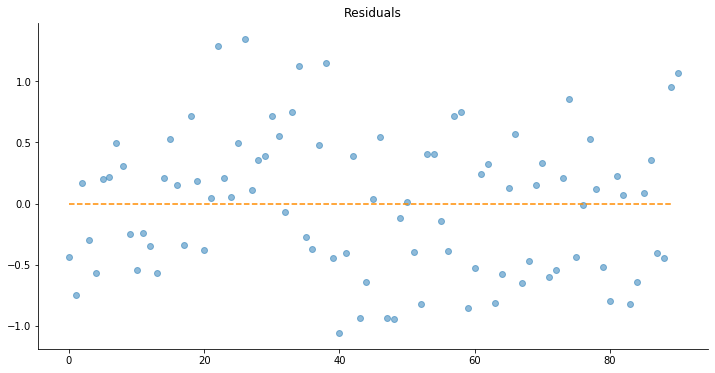

In [117]:
def test_homoscedasticity(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    print('Residuals should have relative constant variance')
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()
test_homoscedasticity(linear_model, Price, Quantity)